In [1]:
import timeit
import warnings
from statistics import stdev, variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from CoolProp.CoolProp import HAPropsSI, PropsSI
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, IFrame, Image
from IPython.display import Markdown as md
from IPython.display import display

from jupyter_datatables import init_datatables_mode
from pandas import concat
from tensorflow import keras


%load_ext jupyter_require
%requirejs d3 https://d3js.org/d3.v5.min
init_datatables_mode()


sns.set_theme()
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={"figure.figsize": (16, 20)})
sns.set(style="darkgrid")
plt.xticks(rotation=45)
# Some IPython magic to remove  the need to invoke show after each plot
%matplotlib inline

warnings.filterwarnings("ignore")

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

The jupyter_require extension is already loaded. To reload it, use:
  %reload_ext jupyter_require


### Load the data

In [2]:
df = pd.read_csv("data/freezer_room.csv")
df.dropna(inplace=True)

### Remove outliers where there are unrealistic readings where probes may have been damaged.

In [3]:
df = df.drop(df[(df["Air Temp"] > 30) | (df["Air Temp"] < -40)].index)

In [5]:
df.info

<bound method DataFrame.info of                 unit   timestamp  Differential  Evaporator  Set Point  \
0       26c560b6eddb  1483833410           3.0       -19.5      -22.0   
1       26c560b6eddb  1483833110           3.0       -19.9      -22.0   
2       26c560b6eddb  1483832810           3.0       -20.4      -22.0   
3       26c560b6eddb  1483832510           3.0       -21.9      -22.0   
4       26c560b6eddb  1483832210           3.0       -21.6      -22.0   
...              ...         ...           ...         ...        ...   
442522  26c560b6eddb  1621124409           4.0       -18.1      -22.0   
442523  26c560b6eddb  1621124109           4.0       -18.2      -22.0   
442524  26c560b6eddb  1621123809           4.0       -18.3      -22.0   
442525  26c560b6eddb  1621123509           4.0       -18.4      -22.0   
442526  26c560b6eddb  1621123209           4.0       -18.6      -22.0   

        Air Temp  
0          -19.5  
1          -19.8  
2          -20.4  
3          -21.

In [6]:
df.dtypes

unit             object
timestamp         int64
Differential    float64
Evaporator      float64
Set Point       float64
Air Temp        float64
dtype: object

### Tidy up some variables

In [8]:
df["unit"] = df.unit.apply(lambda u: u[-8:])
df["date_time"] = pd.to_datetime(df["timestamp"], unit="s")
df.sort_values(by="date_time", inplace=True)
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month
df["cabinet"] = "Freezer Room"


### Get the absolute difference between the airtemt and differential

In [9]:
df["actual_diff"] = df["Set Point"] - df["Air Temp"]
df["actual_diff"] = df.actual_diff.apply(lambda x: abs(x))

### Shift  Air temp to get in 50 minute blocks

In [10]:
df["t+05"] = df["Air Temp"].shift(-1)
df["t+10"] = df["Air Temp"].shift(-2)
df["t+15"] = df["Air Temp"].shift(-3)
df["t+20"] = df["Air Temp"].shift(-4)
df["t+25"] = df["Air Temp"].shift(-5)
df["t+30"] = df["Air Temp"].shift(-6)
df["t+35"] = df["Air Temp"].shift(-7)
df["t+40"] = df["Air Temp"].shift(-8)

### Shift Evaporator temps to get in 50 minute blocks

In [11]:
df["e+05"] = df["Evaporator"].shift(-1)
df["e+10"] = df["Evaporator"].shift(-2)
df["e+15"] = df["Evaporator"].shift(-3)
df["e+20"] = df["Evaporator"].shift(-4)
df["e+25"] = df["Evaporator"].shift(-5)
df["e+30"] = df["Evaporator"].shift(-6)
df["e+35"] = df["Evaporator"].shift(-7)
df["e+40"] = df["Evaporator"].shift(-8)

### Set variance and standard deviation

In [12]:
df["std_dev_temp"] = df[
    [
        "Air Temp",
        "t+05",
        "t+10",
        "t+15",
        "t+20",
        "t+25",
        "t+30",
        "t+35",
        "t+40",
    ]
].std(axis=1)

df["std_dev_evap"] = df[
    [
        "Air Temp",
        "e+05",
        "e+10",
        "e+15",
        "e+20",
        "e+25",
        "e+30",
        "e+35",
        "e+40",
    ]
].std(axis=1)


df["variance_temp"] = df[
    [
        "Air Temp",
        "t+05",
        "t+10",
        "t+15",
        "t+20",
        "t+25",
        "t+30",
        "t+35",
        "t+40",
    ]
].var(axis=1)

df["variance_evap"] = df[
    [
        "Air Temp",
        "e+05",
        "e+10",
        "e+15",
        "e+20",
        "e+25",
        "e+30",
        "e+35",
        "e+40",
    ]
].var(axis=1)

### Helper functions

In [13]:
def _ordered(lst, reverse=False):
    """
    Is a list in order, optionally verify reverse order
    """
    if reverse:
        lst = lst[::-1]
    return bool(len(lst) and sorted(lst) == lst)


def is_faulty(lst, threshold=0):
    """
    Are all the values > a given value
    """
    return all(i > threshold for i in lst)


def is_defrost(lst):

    peak = max(lst)
    max_index = lst.index(peak)
    air_temp = lst[0]
    faulty = is_faulty(lst)

    rise = lst[:max_index]
    fall = lst[max_index:]
    defrosting = (
        not faulty
        and peak >= -5
        and bool(rise and fall)
        and _ordered(rise)
        and _ordered(fall, reverse=True)
    )

    return defrosting, peak, faulty


def is_evaporating(lst):

    peak = max(lst)
    max_index = lst.index(peak)
    air_temp = lst[0]
    faulty = is_faulty(lst, threshold=30)

    rise = lst[:max_index]
    fall = lst[max_index:]
    evaporating = (
        not faulty
        and peak >= 20
        and bool(rise and fall)
        and _ordered(rise)
        and _ordered(fall, reverse=True)
    )

    return evaporating, peak, faulty

### Categorize data

In [14]:
df[["defrost", "peak_d", "faulty_d", "evaporating", "peak_e", "faulty_e"]] = df.apply(
    lambda row: pd.Series(
        is_defrost(
            [
                row["Air Temp"],
                row["t+05"],
                row["t+10"],
                row["t+15"],
                row["t+20"],
                row["t+25"],
                row["t+30"],
                row["t+35"],
                row["t+40"],
            ],
        )
        + is_evaporating(
            [
                row["Air Temp"],
                row["e+05"],
                row["e+10"],
                row["e+15"],
                row["e+20"],
                row["e+25"],
                row["e+30"],
                row["e+35"],
                row["e+40"],
            ],
        )
    ),
    axis=1,
)

#### Defrosting

In [15]:
defrost = df[df["defrost"] == True]
defrost = defrost[["date_time", "Differential", "peak_d"]]
defrost = (
    defrost.groupby([defrost["date_time"].dt.date, "Differential"])["peak_d"]
    .count()
    .reset_index()
)

#### Evaporator

In [16]:
evap = df[df["evaporating"] == True]

evap = evap[["date_time", "Differential", "peak_e"]]
evap = (
    evap.groupby([evap["date_time"].dt.date, "Differential"])["peak_e"]
    .count()
    .reset_index()
)

Distribution of Defrost and Evaporator temperatures

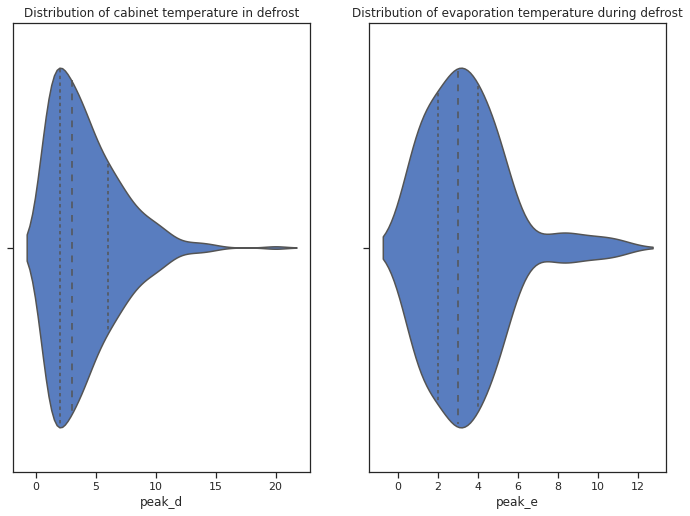

In [17]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(11.7, 8.27)
sns.violinplot(
    data=defrost,
    x="peak_d",
    hue="Differential",
    ax=ax[0],
    palette="muted",
    split=True,
    inner="quartile",
).set(title="Distribution of cabinet temperature in defrost")
sns.violinplot(
    data=evap,
    x="peak_e",
    hue="Differential",
    ax=ax[1],
    palette="muted",
    split=True,
    inner="quartile",
).set(title="Distribution of evaporation temperature during defrost")
fig.show()

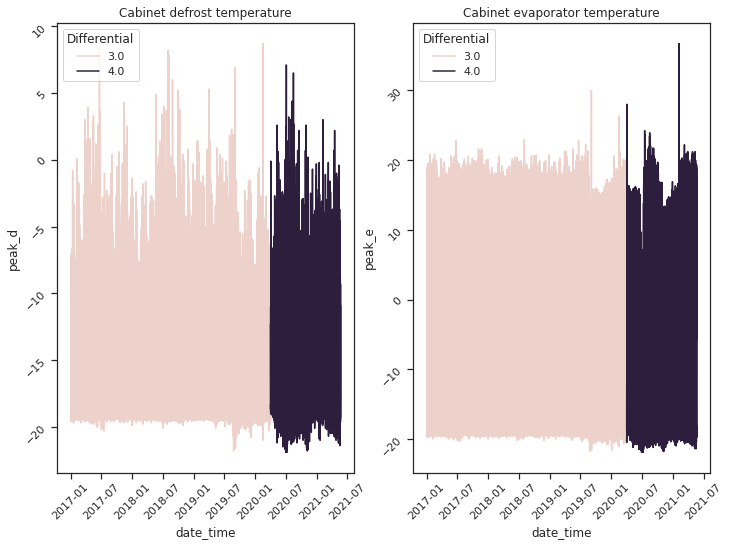

In [18]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(11.7, 8.27)

ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
sns.lineplot(data=df, x="date_time", y="peak_d", ax=ax[0], hue="Differential").set(
    title="Cabinet defrost temperature"
)

sns.lineplot(data=df, x="date_time", y="peak_e", ax=ax[1], hue="Differential").set(
    title="Cabinet evaporator temperature"
)


fig.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

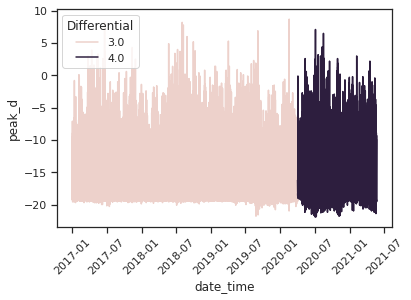

In [19]:
sns.lineplot(data=df, x="date_time", y="peak_d", hue="Differential")
plt.xticks(rotation=45)
plt

### Defrost 

#### pair plot


In [20]:
defrost = df[df["defrost"] == True]
defrost = defrost[
    ["Evaporator", "Air Temp", "peak_d", "peak_e", "std_dev_temp", "variance_temp"]
]

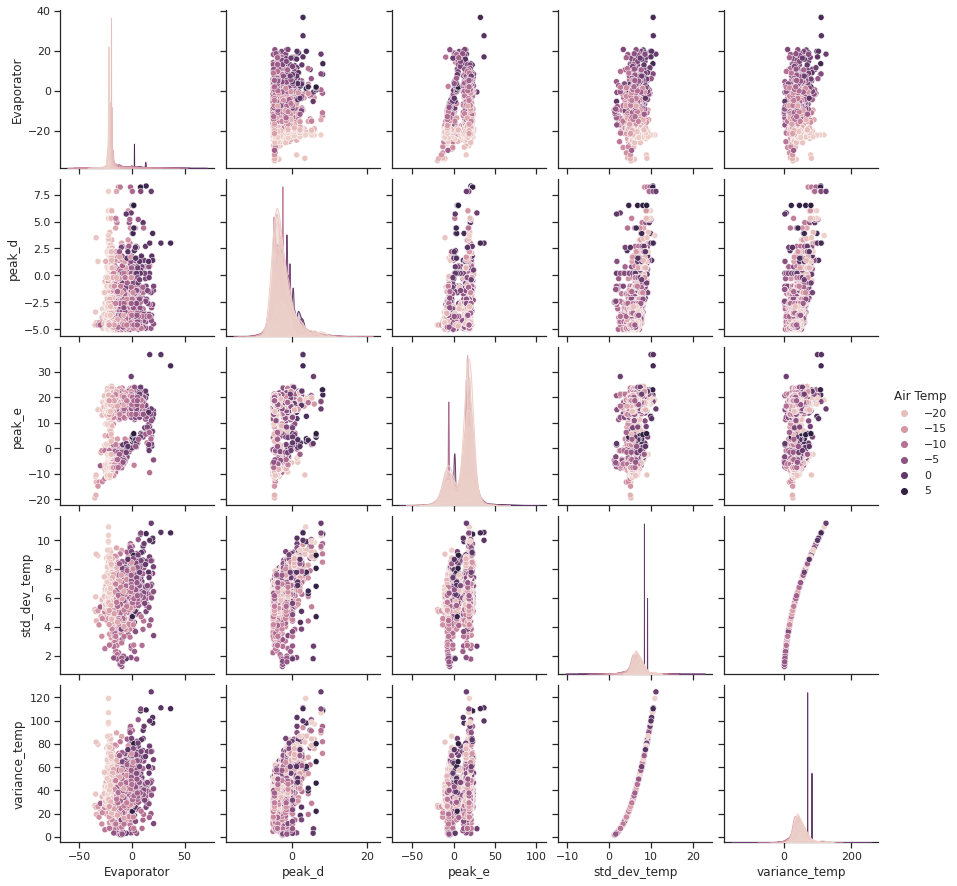

In [21]:
sns.pairplot(
    defrost,
    hue="Air Temp",
)

<AxesSubplot:xlabel='date_time', ylabel='peak_d'>

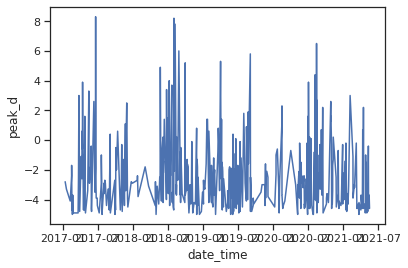

In [28]:
defrost2 = df[df["defrost"] == True]
sns.lineplot(x="date_time", y="peak_d", data=defrost2)

### Evaporation pair plot

In [22]:
evap = df[df["evaporating"] == True]
evap = evap[
    ["Evaporator", "Air Temp", "peak_d", "peak_e", "std_dev_evap", "variance_evap"]
]

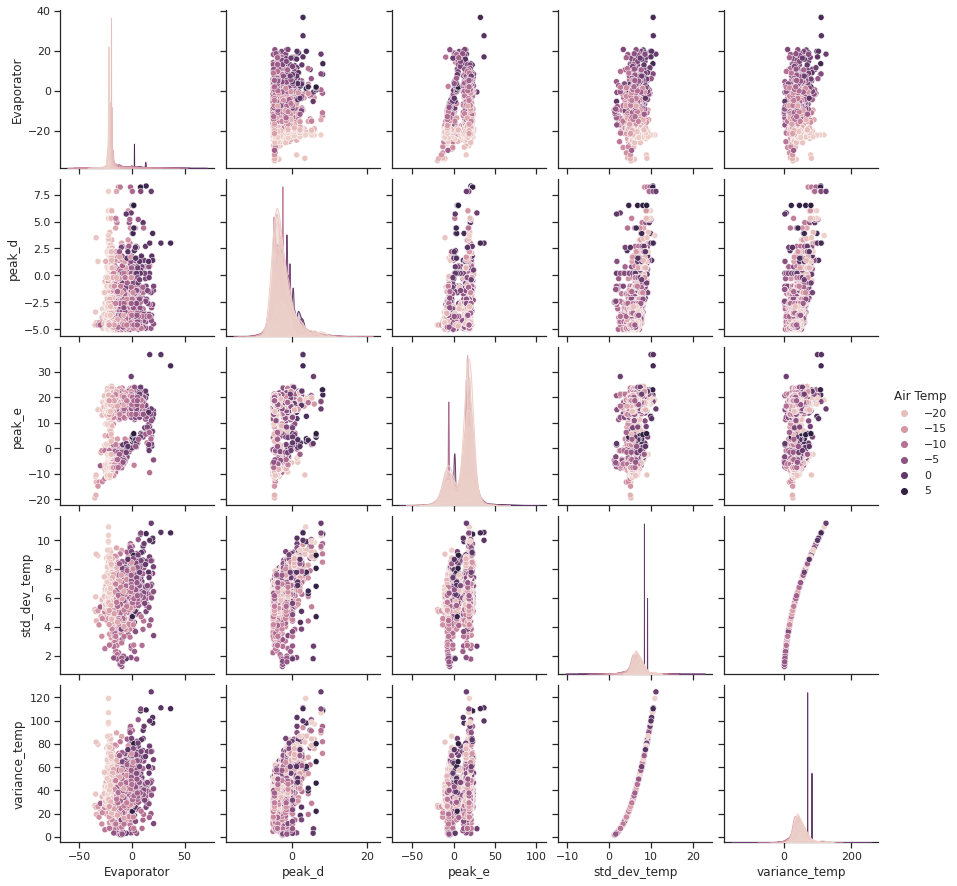

In [23]:
sns.pairplot(
    defrost,
    hue="Air Temp",
)

<AxesSubplot:xlabel='date_time', ylabel='peak_d'>

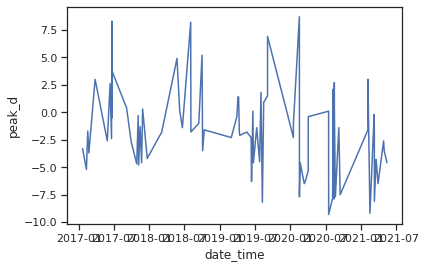

In [24]:
evap2 = df[df["evaporating"] == True]
sns.lineplot(x="date_time", y="peak_d", data=evap2)

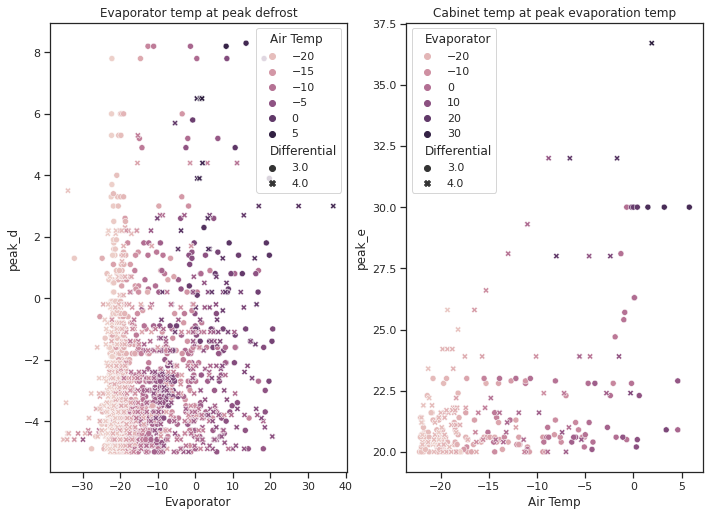

In [29]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(11.7, 8.27)

sns.scatterplot(
    data=defrost2,
    x="Evaporator",
    y="peak_d",
    hue="Air Temp",
    ax=ax[0],
    style="Differential",
).set(title="Evaporator temp at peak defrost")

sns.scatterplot(
    data=evap2,
    x="Air Temp",
    y="peak_e",
    hue="Evaporator",
    style="Differential",
    ax=ax[1],
).set(title="Cabinet temp at peak evaporation temp")

fig.show()

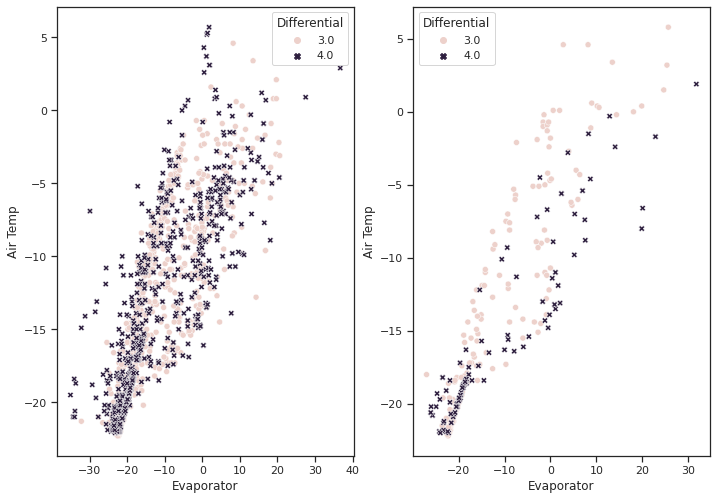

In [30]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(11.7, 8.27)


sns.scatterplot(
    data=defrost2,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[0],
)
sns.scatterplot(
    data=evap2,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[1],
)


fig.show()

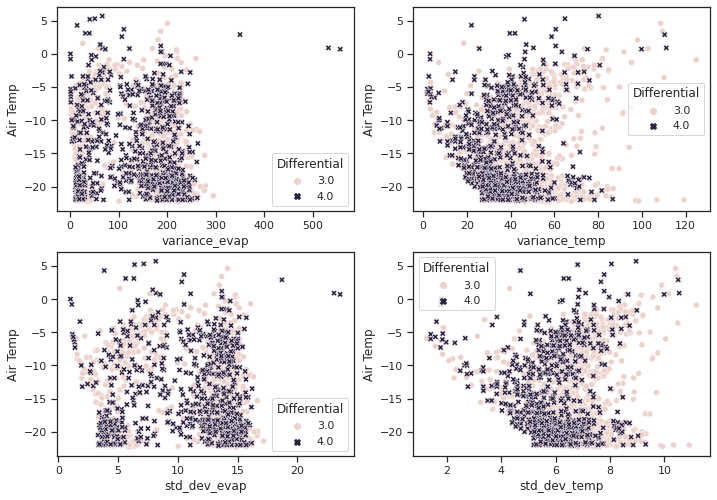

In [31]:
fig, ax = plt.subplots(2, 2)

fig.set_size_inches(11.7, 8.27)


sns.scatterplot(
    data=defrost2,
    x="variance_evap",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[0,0],
)
sns.scatterplot(
    data=defrost2,
    x="variance_temp",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[0,1],
)
sns.scatterplot(
    data=defrost2,
    x="std_dev_evap",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[1,0],
)
sns.scatterplot(
    data=defrost2,
    x="std_dev_temp",
    y="Air Temp",
    hue="Differential",
    style="Differential",
    ax=ax[1,1],
)


fig.show()

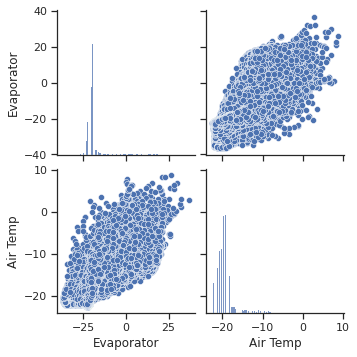

In [32]:
sns.pairplot(df[["Evaporator", "Air Temp"]])

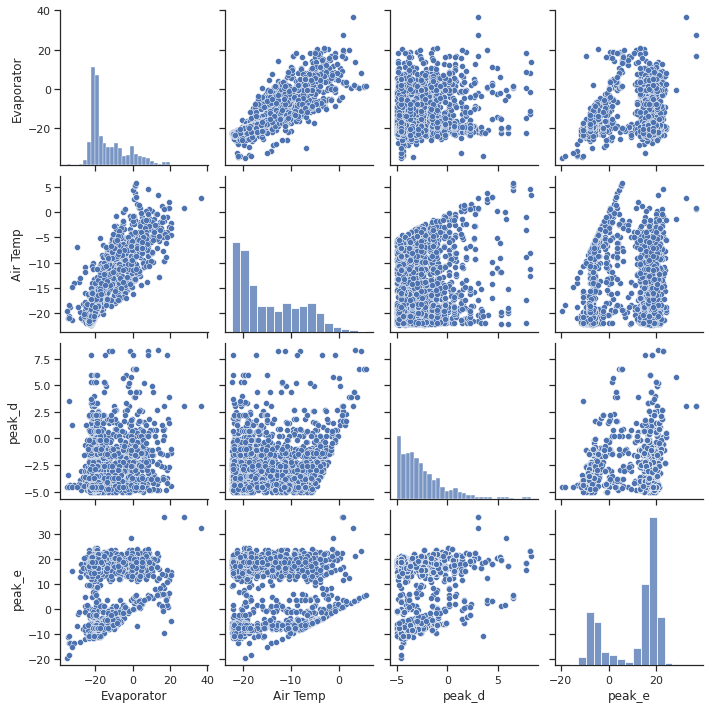

In [33]:
sns.pairplot(defrost[["Evaporator", "Air Temp", "peak_d", "peak_e"]])

State during defrosts

States during evaporation

In [ ]:

sea = sns.FacetGrid(df, row="Air Temp", col="date_time", margin_titles=True)

sea.map(sns.regplot, "id", "pulse", color=".3", fit_reg=False, x_jitter=0.1)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
            data: Sequence of observations as a list or NumPy array.
            n_in: Number of lag observations as input (X).
            n_out: Number of observations as output (y).
            dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
            Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Machine learning

In [ ]:
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

### Modeling
#### Supervised
Regression and classification are two types of supervised machine learning algorithms.

##### Regression:

Predicts continuous value outputs
##### Classification:

Predicts discrete outputs
For example, predicting the price of stocks in the market in euros is a regression problem, and predicting whether someone is smiling in an image is a classification problem.

### Build the model
Building a linear regression model,

Using the mean to get a central tendency for the data distribution.

First remove unwanted cols

In [ ]:
cols_to_drop = [
    "year",
    "month",
    "unit",
    "cabinet",
    "t+05",
    "t+10",
    "t+15",
    "t+20",
    "t+25",
    "t+30",
    "t+35",
    "t+40",
    "e+05",
    "e+10",
    "e+15",
    "e+20",
    "e+25",
    "e+30",
    "e+35",
    "e+40",
]


df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
df.info

An allternatibe to splitting the data this way is to use sklearn.model_selection.train_test_split which takes X, y and test_size and returns a List containing train-test split of inputs.

In [ ]:
train_size = int(len(df) * 0.66)
test_size = len(df) - train_size

train_set = df[0:train_size].reset_index(drop=True)
test_set = df[train_size:].reset_index(drop=True)

training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

### Normalise the data 


#### Normalization

Normalization is a scaling technique in which values are moved and rescaled so that they end up ranging between 0 and 1.

Using the MinMaxScaler, which is  Feature scaling  method used to normalize the range of independent variables or features of data. It is better known as data normalization

1. Create a scaler
    * We are using the MinMaxScaler, there are others like StandardScaler
2. Fit training data to the scaler. 
    * By calling the fit() function, the training data will be used to estimate the minimum and maximum observable values
3. Apply the scale to training data. 
    * This is done by calling the transform() function and Tit  normalise the data for train a model. 

Normalization is ideal to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms where distribution is not asumed. 


#### Standardization

Standardization is a different scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

It is usefull  where the data follows a Gaussian distribution.


#### Gaussian function
Gaussian distribution, better known as normal distribution is a bell-shaped curve. It's assumed that  values will follow a normal distribution with an equal number of measurements above and below the mean value


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

##### Helper function fro splitting a sequence into chunks

In [ ]:
def data_split(sequence, chunk_size=25):
    """
    Split a sequence into a 2d array of at most n chunks in length
    """
    # TODO: use yield
    X = []
    y = []
    for i in range(len(sequence)):
        _ix = i + chunk_size
        if _ix + 1 > len(sequence):
            break

        seq_x, seq_y = sequence[i:_ix], sequence[_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = data_split(training_set_scaled)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
sns.heatmap(train_set.corr(),annot=True,cmap='RdYlGn',linewidths=0.3)
fig=plt.gcf()
fig.set_size_inches(14,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Sequence classification 

Given a sequence of inputs over time, we try to predict a new sequence.

It can be difficult because  the sequences can vary in length, be comprised of a very large vocabulary of input symbols and may require the model to learn the long-term context or dependencies between symbols in the input sequence.


#### LSTM
Long Short-Term Memory (LSTM) networks are a type of recurrent neural networks with the ability to learn in sequence prediction problems.

Recurrent neural networks are different other neural networks because they add new behaviors that are dependent previous state that traditional methods neurel net's didn't have 


LSTM, using its hidden state can  preserve information from inputs that has already passed through it.

The first arg sin the LSTM is `units` which is a positive integer, dimensionality of the output space.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# keeping this low because its slow
num_epochs = 10
num_lstm_units = 10

model = Sequential()


In [ ]:
model.add(
    LSTM(
        num_lstm_units,
        activation="relu",
        recurrent_activation="sigmoid",
        input_shape=(X_train.shape[1], 1),
    ),
)
model.add(Dense(units=1))

#### Build the model


Now, it’s time to build the models. 

We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer. Note: the following will take some time  model.compile optimizer = 'adam', loss = 'mean_squared_error')

Adadelta: Optimizer that implements the Adadelta algorithm.
Adagrad: Optimizer that implements the Adagrad algorithm.
Adam: Optimizer that implements the Adam algorithm.
Adamax: Optimizer that implements the Adamax algorithm.
Ftrl: Optimizer that implements the FTRL algorithm.
Nadam: Optimizer that implements the NAdam algorithm.
Optimizer: Base class for Keras optimizers.
RMSprop: Optimizer that implements the RMSprop algorithm.
SGD: Gradient descent (with momentum) optimizer.

Using theAdaptive Moment Estimation(Adam) optimizer  because it has low memory requirements even though it can be higher than gradient descent. It computes adaptive learning rates for each parameter as well as keeping track of  the decaying average of past squared gradients 


This is very slow even with only around 8K data points for 2 varables

##### Epoch & Batch
A number of epochs means how many times you go through your training set.

The model is updated each time a batch is processed, which means that it can be updated multiple times during one epoch. If batch_size is set equal to the length of x, then the model will be updated once per epoch.

According to the Keras documentation epochs defines the number of times you iterate over the training set and the batch_size is the number of samples processed in paralell

##### Compile model 

__This is very slow__

Using the adam optimizer and the mean_squared_error for the regression loses

When fitting the model we are keeping the epochs low (1) to speed things up. The number of epochs reflects the number of iterations over the entire set, used to separate training into distinct phases, which can be useful for periodic evaluation.

In [ ]:
import timeit

starttime = timeit.default_timer()

model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
# Keeping batch size high to increase speed, but it potentially decreases accuracy
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64)
loss1 = history.history["loss"]
epochs1 = range(len(loss1))

model_runtime = timeit.default_timer() - starttime

In [ ]:
print(
    "The compile time for model  LSTM using adam and batch size of 64 was:",
    model_runtime,
)

###  Get predicted data

#### LSTM



Model.predict.ravel() returns a list of x,y coordinates



In [ ]:
print(history.history['loss'])
print(history.history['accuracy'])

In [ ]:
lstm_y_predicted = model.predict(X_test)
lstm_y_predicted_descaled = sc.inverse_transform(lstm_y_predicted)
lstm_y_train_descaled = sc.inverse_transform(y_train)
lstm_y_test_descaled = sc.inverse_transform(y_test)
lstm_y_pred = lstm_y_predicted.ravel()
lstm_y_tested = y_test.ravel()

In [ ]:
plt.plot(lstm_y_test_descaled, color="green", label="Actual")
plt.plot(lstm_y_predicted_descaled, color="red", label="Predicted")
plt.legend(frameon=False)
plt.title("LSTM Predicted")

### Regression

In [27]:
df2=df[['Air Temp', 'Evaporator']]

train_size = int(len(df2) * 0.66)
test_size = len(df2) - train_size

train_set = df2[0:train_size].reset_index(drop=True)
test_set = df2[train_size:].reset_index(drop=True)

training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values



X_train, y_train = data_split(training_set_scaled)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


NameError: name 'data_split' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))



#### Alternative Models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#### define a function that trains model

In [ ]:
def train_model(model):
    model_ = model
    model_.fit(X_train, y_train)
    y_preds = model_.predict(X_val)
    return get_scores(y_preds, y_val)

In [ ]:
model_list = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    LogisticRegression(random_state=42),
    svm.SVC(random_state=42),
    AdaBoostClassifier(random_state=42),
]
model_names = [
    "Decision Tree",
    "Random Forest",
    "Logistic Regression",
    "SVM",
    "AdaBoost",
]

In [ ]:
# Now lets train all the models and see how are they doing

scores = pd.DataFrame(columns=['Name','Accuracy','Precision',
                                'Recall',
                                'F1',
                                'ROC_AUC'])
for i in range(len(model_list)):
    score=train_model(model_list[i])
    scores.loc[i]=[model_names[i]]+list(score.values())

# figure, axis = plt.subplots(2, 3)
# figure.set_figheight(15)
# figure.set_figwidth(20)

# for i in range(2):
#     for j in range(3):
#         axis[i,j].set_xlim([.5,.9])
        
# axis[0, 0].barh(scores['Name'],scores['Accuracy'],height=.5)
# axis[0, 0].set_title("Accuracy Score")
  
# axis[0, 1].barh(scores['Name'],scores['Precision'],height=.5)
# axis[0, 1].set_title("Precision")

# axis[1, 0].barh(scores['Name'],scores['Recall'],height=.5)
# axis[1, 0].set_title("Recall")

# axis[1, 2].barh(scores['Name'],scores['F1'],height=.5)
# axis[1, 2].set_title("F1")

# axis[0, 2].barh(scores['Name'],scores['ROC_AUC'],height=.5)
# axis[0, 2].set_title('ROC_AUC')

# axis[1, 1].set_visible(False)

plt.show()


#### Hyperparameter Tuning¶
Alright, It's time for hyper parameter tuning!. We'll use GridSearchCV to find the best permutaion of hyper parameters for the mode

#####  defining what all parameters we want to tune for all models

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.utils.fixes import loguniform
param_grids = [

    {
        'max_depth': [5,7,10,20,50],
        'min_samples_leaf': [4, 5, 6, 7],
        'min_samples_split': [8, 10,7],
    },
    {
        'max_depth': [5,7, 20],
        'min_samples_leaf': [4, 5, 6, 7],
        'min_samples_split': [6,7,8],
        'n_estimators': [100,500],
        'oob_score' : [True],
        'max_features' :['auto'],
    },
    {
        'max_depth': [3, 5, 9], 
        'n_estimators': [5, 50, 100],
        'learning_rate': [0.01]
    },
    {
        'learning_rate': [0.1,.2],
        'num_leaves': [100,200,150,300],
        'n_estimators':[5, 20, 50, 100],
        'boosting_type' : ['gbdt'],
        'objective' : ['binary'],
        'max_depth' : [10,25,50,100,150], 
        'colsample_bytree' : [0,3,0.5,0.7],
        'subsample' : [0.3,0.5,0.7],
        'min_split_gain' : [0.01],
    },
    {
        'penalty' : ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 20),
        'solver' : ['liblinear']
    },
    {
        'C': [0.1,1, 10, 100], 
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    {
        'learning_rate': [0.1],
        'depth': [4, 10],
        'l2_leaf_reg': [ 5, 7, 9]
    },
    {
        'n_estimators':[10,50,250,1000],
        'learning_rate':[0.01,0.1]
    }
]

####  start the search

In [ ]:


tuned_scores=scores.drop(scores.index)
tuned_models=[]
def grid_search_util(i):
    grid_search = GridSearchCV(estimator = model_list[i], param_grid = param_grids[i], 
                          cv = 3, n_jobs = -1,verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

for i in range(len(model_list)):
    model=grid_search_util(i)
    tuned_models.append(model)
    score=train_model(model)
    tuned_scores.loc[i]=[model_names[i]]+list(score.values())
    print(model_names[i]," Done")

#### Plot the outputs

In [ ]:
figure, axis = plt.subplots(2, 3)
figure.set_figheight(15)
figure.set_figwidth(20)

for i in range(2):
    for j in range(3):
        axis[i,j].set_xlim([.5,.9])
axis[0, 0].barh(tuned_scores['Name'],tuned_scores['Accuracy'],height=.5)
axis[0, 0].set_title("Accuracy Score")


axis[0, 1].barh(tuned_scores['Name'],tuned_scores['Precision'],height=.5)
axis[0, 1].set_title("Precision")

axis[1, 0].barh(tuned_scores['Name'],tuned_scores['Recall'],height=.5)
axis[1, 0].set_title("Recall")

axis[1, 2].barh(tuned_scores['Name'],tuned_scores['F1'],height=.5)
axis[1, 2].set_title("F1")

axis[0, 2].barh(tuned_scores['Name'],tuned_scores['ROC_AUC'],height=.5)
axis[0, 2].set_title('ROC_AUC')

axis[1, 1].set_visible(False)
plt.show(